In [ ]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import numpy as np
import random

# Introduction
This notebook analyzes discussions in Reddit communities focused on Israel and Judaism, covering the period from October 2023 to November 2024. Using sentiment analysis, topic modeling, entity recognition, and network analysis, we examine how discourse evolves in response to key events, who the leading voices are, and how sentiment shifts over time. Special focus is given to identifying peak dates and understanding the dominant topics discussed during these critical moments.

In [ ]:
all_posts = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/all_subreddits_submissions.csv")
all_comments = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/all_subreddits_comments.csv")

posts_topics = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/models/LDA/posts_with_lda_topics.csv")
comments_topics = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/models/LDA/comments_with_topics.csv")

/tmp/ipykernel_100407/4136312757.py:1: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  all_posts = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/all_subreddits_submissions.csv")
/tmp/ipykernel_100407/4136312757.py:2: DtypeWarning: Columns (4,30) have mixed types. Specify dtype option on import or set low_memory=False.
  all_comments = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/all_subreddits_comments.csv")
/tmp/ipykernel_100407/4136312757.py:5: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_topics = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/models/LDA/comments_with_topics.csv")


In [ ]:
comments_topics['lda_topic'] = pd.to_numeric(
    comments_topics['lda_topic'],
    errors='coerce'
).fillna(-1).astype(int)

comments_topics = comments_topics[comments_topics['lda_topic'] != -1]

In [ ]:
# Merging posts tables
merged_posts = posts_topics.merge(
    all_posts,
    on='id',
    how='inner'
)

# Merging comments tables
merged_comments = comments_topics.merge(
    all_comments,
    on='id',
    how='inner'
)

In [ ]:
merged_posts['date'] = pd.to_datetime(merged_posts['created_utc']).dt.date
merged_comments['date'] = pd.to_datetime(merged_comments['created_utc']).dt.date

In [ ]:
# Combine Posts and Comments into a single DataFrame
# Use 'combined_text' for posts and 'body_x' for comments
merged_posts['full_text'] = merged_posts['combined_text'].fillna('')
merged_comments['full_text'] = merged_comments['body_x'].fillna('')

In [ ]:
# Combine Posts and Comments
combined = pd.concat([
    merged_posts[['subreddit', 'date', 'lda_topic', 'full_text']],
    merged_comments[['subreddit', 'date', 'lda_topic', 'full_text']]
])

In [ ]:
combined

,subreddit,date,lda_topic,full_text
0,Israel,2023-10-01,0,Houthi Music Video Threatening Israel: The Zio...
1,Israel,2023-10-01,1,A peace deal between the Saudis and Israelis c...
2,Israel,2023-10-01,4,is it true the 40% of israelis think of immigr...
3,Israel,2023-10-01,1,Queer in Jerusalem I am out and proud Queer ma...
4,Israel,2023-10-01,7,"Is there still racism between askenzai, sephar..."
...,...,...,...,...
1012349,ReformJews,2024-11-30,7,"My sibling in Moshe, what drugs have you been ..."
1012350,ReformJews,2024-11-30,6,"""steal our stuff"" is quite mean if you meant t..."
1012351,ReformJews,2024-11-30,6,You are not for us. Sorry. I don't mean that i...
1012352,ReformJews,2024-11-30,7,The services I attend at my Reform synagogue a...


In [ ]:
# This mapping should match the LDA model used in the initial analysis
topic_labels = {
    0: "Conflict & Politics",
    1: "Religious Identity",
    2: "Culture & Antisemitism",
    3: "Settlements & Nationalism",
    4: "Terrorism & Violence",
    5: "Holidays & Traditions",
    6: "Global Politics & Leaders",
    7: "Campus Protests & Free Speech"
}
combined['lda_topic_label'] = combined['lda_topic'].map(topic_labels)

In [ ]:
import nltk
nltk.download('vader_lexicon')

# Initialize SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 0
    return analyzer.polarity_scores(text)['compound']

combined['sentiment'] = combined['full_text'].apply(get_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/weissroy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
combined

,subreddit,date,lda_topic,full_text,lda_topic_label,sentiment
0,Israel,2023-10-01,0,Houthi Music Video Threatening Israel: The Zio...,Conflict & Politics,-0.7506
1,Israel,2023-10-01,1,A peace deal between the Saudis and Israelis c...,Religious Identity,0.5423
2,Israel,2023-10-01,4,is it true the 40% of israelis think of immigr...,Terrorism & Violence,0.7915
3,Israel,2023-10-01,1,Queer in Jerusalem I am out and proud Queer ma...,Religious Identity,0.8726
4,Israel,2023-10-01,7,"Is there still racism between askenzai, sephar...",Campus Protests & Free Speech,-0.6249
...,...,...,...,...,...,...
1012349,ReformJews,2024-11-30,7,"My sibling in Moshe, what drugs have you been ...",Campus Protests & Free Speech,0.0000
1012350,ReformJews,2024-11-30,6,"""steal our stuff"" is quite mean if you meant t...",Global Politics & Leaders,-0.4939
1012351,ReformJews,2024-11-30,6,You are not for us. Sorry. I don't mean that i...,Global Politics & Leaders,-0.3158
1012352,ReformJews,2024-11-30,7,The services I attend at my Reform synagogue a...,Campus Protests & Free Speech,0.8875


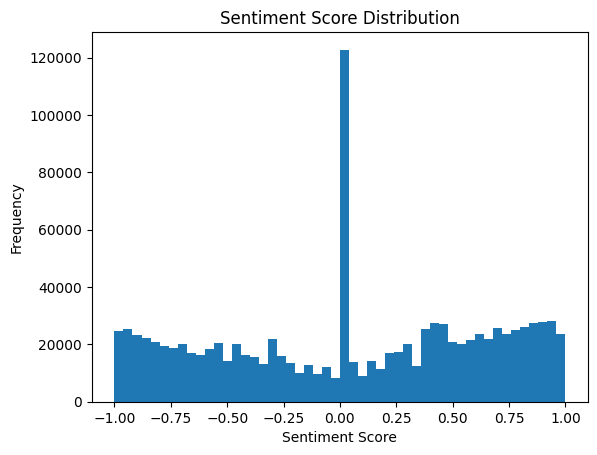

In [ ]:
plt.hist(combined['sentiment'], bins=50)
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#  Function to bucket sentiment scores into rough categories
def bucket_sentiment(score):
    if score > 0.5:
        return 'Strong Positive'
    elif score > 0.1:
        return 'Mild Positive'
    elif score < -0.5:
        return 'Strong Negative'
    elif score < -0.1:
        return 'Mild Negative'
    else:
        return 'Neutral'

combined['sentiment_bucket'] = combined['sentiment'].apply(bucket_sentiment)

In [ ]:
# Function to print random examples from each bucket
def print_examples(bucket, n=5):
    print(f"\n--- {bucket.upper()} EXAMPLES ---")
    examples = combined[combined['sentiment_bucket'] == bucket]['full_text'].sample(n, random_state=42)
    for idx, text in enumerate(examples):
        print(f"{idx+1}. {text}\n")

# Loop over all buckets and print examples
buckets = ['Strong Positive', 'Mild Positive', 'Neutral', 'Mild Negative', 'Strong Negative']

for bucket in buckets:
    print_examples(bucket)



--- STRONG POSITIVE EXAMPLES ---
1. If you don't live in Isarel and are in direct contact with the orthodox community this can be misleading. They really, full heartedly, don't give a F about this and most definitely won't enlist until their religious leaders will tell them to do so. They are very happy with how things are at the moment, when they get to skip mandatory service but still get to have tax favors and discounts to study religion

2. Az Yashir is only important for the two lines, and v’yvarech like half of it. They have specific purposes in tefila and this collection gets you from asiya to atzilut. For men this is the bare minimum to accomplish the job, women is a q.

3. Stephen Harper, the man who made Pierre Poilievre and the man who _founded_ the CPC party is an Evangelical Christian.
The Alliance Church, to which Harper has belonged for decades, believes Jesus Christ will return to Earth in an apocalypse, won’t ordain women, strongly opposes abortion and divorce, condem

In [ ]:
# 4. Sentiment Classification - Convert Sentiment Score to Categories
def classify_sentiment(score):
    if score > 0.2:
        return 'Positive'
    elif score < -0.2:
        return 'Negative'
    else:
        return 'Neutral'

combined['sentiment_label'] = combined['sentiment'].apply(classify_sentiment)

In [ ]:
## Sentiment per topic

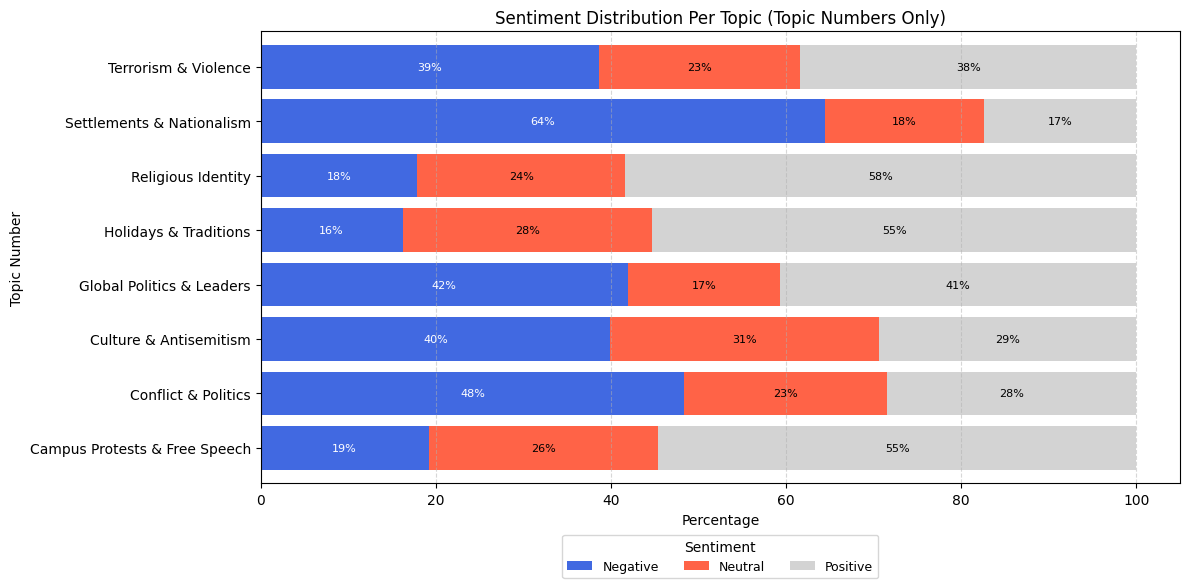

In [ ]:
# Sentiment Distribution Per Topic
sentiment_dist = combined.groupby(['lda_topic_label', 'sentiment_label']).size().unstack(fill_value=0)

# Calculate percentage for each sentiment within each topic
sentiment_dist_percent = sentiment_dist.div(sentiment_dist.sum(axis=1), axis=0) * 100

# Create figure
plt.figure(figsize=(12, 6))

# Horizontal stacked bar plot with specified colors
sentiment_dist_percent.plot(kind='barh', stacked=True,
                            color=['royalblue', 'tomato', 'lightgrey'],
                            ax=plt.gca(), width=0.8)

# Set topic numbers on Y-axis (only numbers 0-7) and set color to black
plt.yticks(range(len(sentiment_dist_percent.index)),
           sentiment_dist_percent.index,
           fontsize=10, color='black')

# Add percentages inside the bars
for i, (topic, row) in enumerate(sentiment_dist_percent.iterrows()):
    cumulative = 0
    for sentiment, percentage in row.items():
        if percentage > 5:  # Only if wide enough to hold text
            text_color = 'white' if sentiment == 'Negative' else 'black'
            plt.text(cumulative + percentage / 2, i, f'{percentage:.0f}%',
                     ha='center', va='center', color=text_color, fontsize=8)
        cumulative += percentage

# Title and labels
plt.title('Sentiment Distribution Per Topic (Topic Numbers Only)', fontsize=12)
plt.xlabel('Percentage', fontsize=10)
plt.ylabel('Topic Number', fontsize=10)

# Legend at bottom, horizontal
plt.legend(title='Sentiment', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=9)

# Grid and layout adjustments
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Print Full Sentences by Sentiment Per Topic
def print_sentences_by_topic_and_sentiment(topic, sentiment_label, max_examples=5):
    subset = combined[(combined['lda_topic_label'] == topic) & (combined['sentiment_label'] == sentiment_label)]
    sentences = subset['full_text'].sample(min(len(subset), max_examples), random_state=42).tolist()

    print(f"\n=== {topic} - {sentiment_label} Examples ===")
    if sentences:
        for idx, sentence in enumerate(sentences, 1):
            print(f"{idx}. {sentence}")
    else:
        print("No examples found.")

# Loop over topics and sentiments to print examples
for topic in topic_labels.values():
    for sentiment in ['Positive', 'Negative', 'Neutral']:
        print_sentences_by_topic_and_sentiment(topic, sentiment)


=== Conflict & Politics - Positive Examples ===
1. Do the math &#x200B;

1948 [War of Independence](https://en.wikipedia.org/wiki/1948_Palestine_war)  
Israel 806.900 vs 17.760.000 Ratio 1:22  
Egypt Iraq Jordan Transjordan Syria Lebanon Saudi Arabia Yemen  
Outcome: Israel won

1967 [Six-Day War](https://en.wikipedia.org/wiki/Six-Day_War)  
Israel 2.776.000 vs 48.108.000 Ratio 1:17  
Egypt Syria Jordan Iraq  
Outcome: Israel won

1973 [Yom Kippur War](https://en.wikipedia.org/wiki/Yom_Kippur_War)  
Israel 3.200.000 vs 82.000.000 Ratio 1:25  
Egypt Syria Iraq Jordan Algeria Morocco Saudi Arabia  
outcome: Israel won  


do the math.

https://preview.redd.it/g57cnhyk7gwc1.png?width=532&format=png&auto=webp&s=746025e43690239292ad31d8a4f05adc08a1c2f9
2. Wagenknecht simply does/says what her sugar daddy Putin tells her. She also vehemently demands that we should no longer support Ukraine and so on. She and her party act as the Kremlin's extended arm in Germany.
3. The article states that 

## Sentiment per subreddit

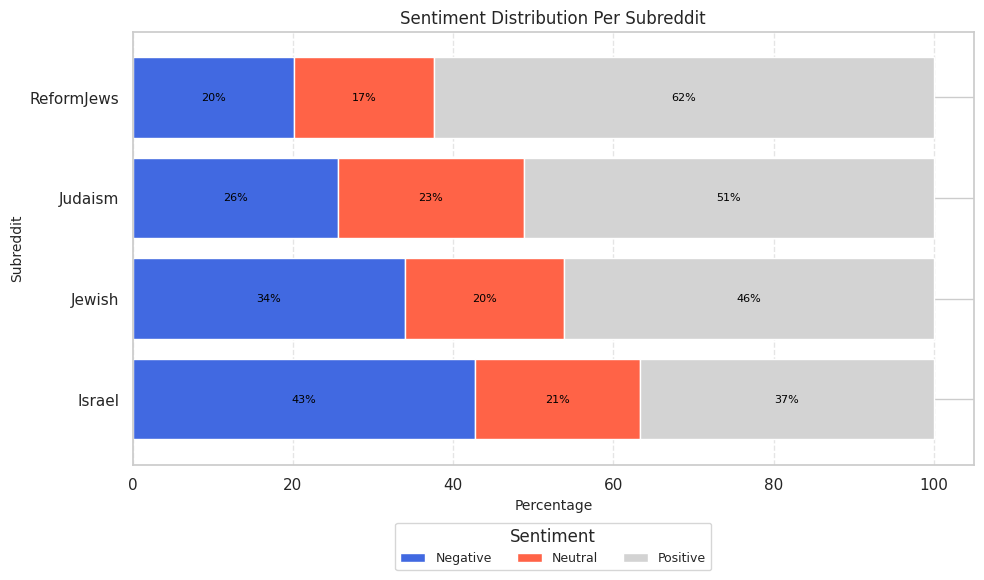

In [ ]:
# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Calculate sentiment distribution per subreddit
sentiment_dist_subreddit = combined.groupby(['subreddit', 'sentiment_label']).size().unstack(fill_value=0)

# Calculate percentage for each sentiment within each subreddit
sentiment_dist_percent = sentiment_dist_subreddit.div(sentiment_dist_subreddit.sum(axis=1), axis=0) * 100

# Plot horizontal stacked bar chart for sentiment distribution per subreddit
plt.figure(figsize=(10, 6))

sentiment_dist_percent.plot(kind='barh', stacked=True,
                            color=['royalblue', 'tomato', 'lightgrey'],
                            ax=plt.gca(), width=0.8)


for i, (subreddit, row) in enumerate(sentiment_dist_percent.iterrows()):
    cumulative = 0
    for sentiment, percentage in row.items():
        if percentage > 5:
            plt.text(cumulative + percentage / 2, i, f'{percentage:.0f}%',
                     ha='center', va='center', fontsize=8, color='black')
        cumulative += percentage

# Title and labels
plt.title('Sentiment Distribution Per Subreddit', fontsize=12)
plt.xlabel('Percentage', fontsize=10)
plt.ylabel('Subreddit', fontsize=10)

# Legend below the plot
plt.legend(title='Sentiment', loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3, fontsize=9)

# Grid and layout
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# Print sample sentences for each sentiment in each subreddit
for subreddit in combined['subreddit'].unique():
    print(f"\n=== Subreddit: {subreddit} ===")

    for sentiment in ['Positive', 'Negative', 'Neutral']:
        print(f"\n--- {sentiment} Examples ---")
        examples = combined[(combined['subreddit'] == subreddit) &
                            (combined['sentiment_label'] == sentiment)]['full_text'].dropna().head(5).tolist()

        if examples:
            for idx, sentence in enumerate(examples, 1):
                print(f"{idx}. {sentence}")
        else:
            print("No examples found.")


=== Subreddit: Israel ===

--- Positive Examples ---
1. A peace deal between the Saudis and Israelis could change everything: Fareed Zakaria 
2. is it true the 40% of israelis think of immigration from Israel ?! Is it true ?! If so why ?!
3. Queer in Jerusalem I am out and proud Queer man (very straight passing though) moving in 2024 to Jerusalem to study at Hebrew Uni for 2 years. 

Uni website says the campus itself is very queer friendly, I wonder if Jerusalem is like that as well? I mean I am planning to get into dating market there as well but, do not want to danger my life over my sexual identity.
4. Separation between religion and state… what are your thoughts? Jew from California here…
Just wanted to get everyone’s thoughts!

I know this is a bit of older news and please forgive me for my naiveness.

The event that happened on Yom Kippur in Tel Aviv were a bit disturbing to me, I was trying to see both sides of the perspective and it kind of makes sense that Tel aviv is aiming

## Average Sentiment Over Time for Each Subreddit

In [ ]:
combined

,subreddit,date,lda_topic,full_text,lda_topic_label,sentiment,sentiment_bucket,sentiment_label
0,Israel,2023-10-01,0,Houthi Music Video Threatening Israel: The Zio...,Conflict & Politics,-0.7506,Strong Negative,Negative
1,Israel,2023-10-01,1,A peace deal between the Saudis and Israelis c...,Religious Identity,0.5423,Strong Positive,Positive
2,Israel,2023-10-01,4,is it true the 40% of israelis think of immigr...,Terrorism & Violence,0.7915,Strong Positive,Positive
3,Israel,2023-10-01,1,Queer in Jerusalem I am out and proud Queer ma...,Religious Identity,0.8726,Strong Positive,Positive
4,Israel,2023-10-01,7,"Is there still racism between askenzai, sephar...",Campus Protests & Free Speech,-0.6249,Strong Negative,Negative
...,...,...,...,...,...,...,...,...
1012349,ReformJews,2024-11-30,7,"My sibling in Moshe, what drugs have you been ...",Campus Protests & Free Speech,0.0000,Neutral,Neutral
1012350,ReformJews,2024-11-30,6,"""steal our stuff"" is quite mean if you meant t...",Global Politics & Leaders,-0.4939,Mild Negative,Negative
1012351,ReformJews,2024-11-30,6,You are not for us. Sorry. I don't mean that i...,Global Politics & Leaders,-0.3158,Mild Negative,Negative
1012352,ReformJews,2024-11-30,7,The services I attend at my Reform synagogue a...,Campus Protests & Free Speech,0.8875,Strong Positive,Positive


In [ ]:
# Make sure date is datetime64 and not just string
combined['date'] = pd.to_datetime(combined['date'])

# Group to calculate average sentiment per subreddit per day
daily_sentiment = combined.groupby(['date', 'subreddit'])['sentiment'].mean().reset_index()

# Function to find min/max date for each subreddit
def find_extreme_dates(subreddit_df):
    if subreddit_df.empty or subreddit_df['sentiment'].isnull().all():
        return pd.Series({'min_sentiment_date': None, 'max_sentiment_date': None})

    min_sentiment_date = subreddit_df.loc[subreddit_df['sentiment'].idxmin(), 'date']
    max_sentiment_date = subreddit_df.loc[subreddit_df['sentiment'].idxmax(), 'date']

    return pd.Series({'min_sentiment_date': min_sentiment_date, 'max_sentiment_date': max_sentiment_date})

# Apply this function per subreddit
extreme_dates = daily_sentiment.groupby('subreddit').apply(find_extreme_dates).reset_index()

# Show result
print(extreme_dates)


    subreddit min_sentiment_date max_sentiment_date
0      Israel         2024-10-07         2024-11-20
1      Jewish         2024-03-05         2023-10-04
2     Judaism         2024-05-11         2024-07-20
3  ReformJews         2024-07-07         2024-09-26


/tmp/ipykernel_100407/1266807887.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  extreme_dates = daily_sentiment.groupby('subreddit').apply(find_extreme_dates).reset_index()


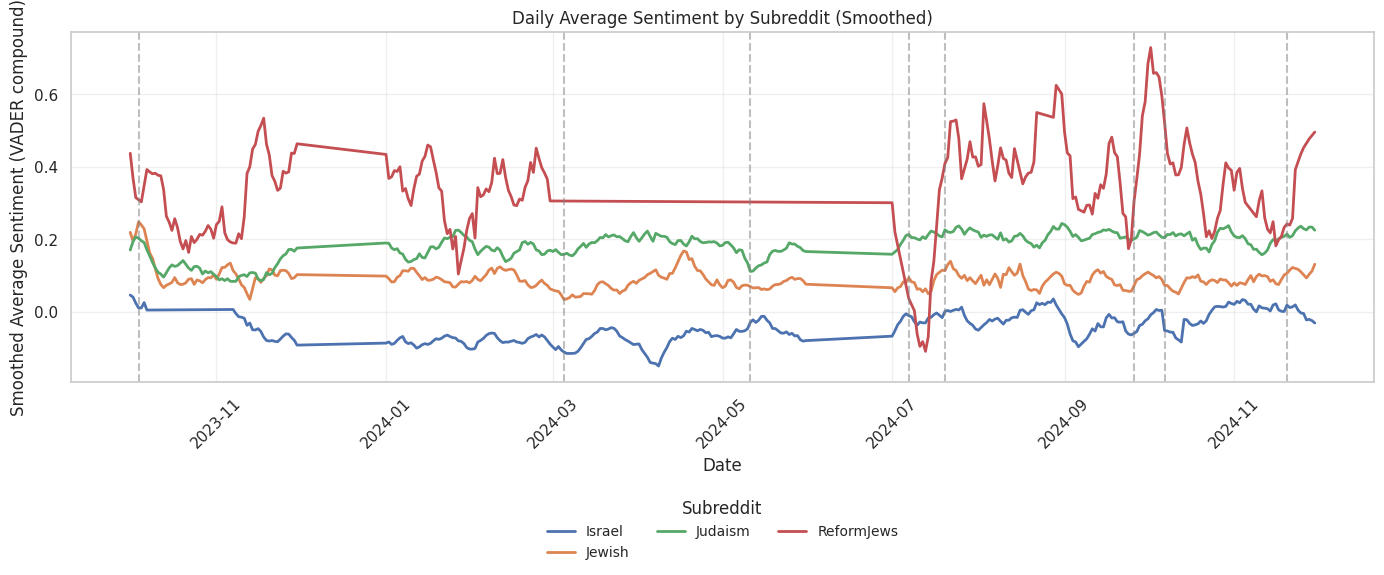

In [ ]:
# Apply rolling mean with a 7-day window to smooth out noise
daily_sentiment['smoothed_sentiment'] = daily_sentiment.groupby('subreddit')['sentiment'].transform(lambda x: x.rolling(7, min_periods=1).mean())

plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_sentiment, x='date', y='smoothed_sentiment', hue='subreddit', marker='', linewidth=2)

# Highlight extreme dates
for i, row in extreme_dates.iterrows():
    plt.axvline(pd.to_datetime(row['min_sentiment_date']), color='gray', linestyle='dashed', alpha=0.5)
    plt.axvline(pd.to_datetime(row['max_sentiment_date']), color='gray', linestyle='dashed', alpha=0.5)

plt.title('Daily Average Sentiment by Subreddit (Smoothed)')
plt.xlabel('Date')
plt.ylabel('Smoothed Average Sentiment (VADER compound)')
plt.xticks(rotation=45)
plt.legend(title='Subreddit', bbox_to_anchor=(0.5, -0.3), loc='upper center', ncol=3, fontsize='small', frameon=False)
plt.subplots_adjust(bottom=0.25)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Define the event window size (how many days before/after the peak to include)
WINDOW_BEFORE = 1
WINDOW_AFTER = 1

# Function to get all posts for a given subreddit and date window
def get_posts_for_window(subreddit, window):
    return combined[
        (combined['subreddit'] == subreddit) &
        (combined['date'].isin(window))
    ][['date', 'full_text']]

# Function to create the event window (date +/- days)
def get_event_window(date, days_before=1, days_after=1):
    return pd.date_range(start=date - pd.Timedelta(days=days_before),
                         end=date + pd.Timedelta(days=days_after)).date

# Collect all posts for each subreddit in the min/max dates
all_events_posts = []

for idx, row in extreme_dates.iterrows():
    subreddit = row['subreddit']

    for date_type in ['min_sentiment_date', 'max_sentiment_date']:
        peak_date = pd.to_datetime(row[date_type]).date()
        window = get_event_window(peak_date, days_before=WINDOW_BEFORE, days_after=WINDOW_AFTER)

        posts = get_posts_for_window(subreddit, window)

        for _, post_row in posts.iterrows():
            all_events_posts.append({
                'subreddit': subreddit,
                'date': post_row['date'],
                'date_type': date_type.replace('_sentiment_date', ''),  # "min" or "max"
                'full_text': post_row['full_text']
            })

# Convert all collected posts to DataFrame
events_df = pd.DataFrame(all_events_posts)

/tmp/ipykernel_100407/3795854833.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  (combined['date'].isin(window))
/tmp/ipykernel_100407/3795854833.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  (combined['date'].isin(window))
/tmp/ipykernel_100407/3795854833.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  (combined['date'].isin(window))
/tmp/ipykernel_100407/379

In [ ]:
events_df

,subreddit,date,date_type,full_text
0,Israel,2024-10-06,min,Ryan McBeth followed up and made some correcti...
1,Israel,2024-10-06,min,"Israel Considers Option of Exiling Sinwar, Ham..."
2,Israel,2024-10-06,min,Refreshing to see an objective historical revi...
3,Israel,2024-10-06,min,France 🇫🇷: Surrendering to evil since 1940 Sou...
4,Israel,2024-10-06,min,Do the rockets carry explosives? It seems when...
...,...,...,...,...
11061,ReformJews,2024-09-26,max,My rabbis (Reform) would probably say if you d...
11062,ReformJews,2024-09-27,max,The creator was quoted in Vogue saying: “I con...
11063,ReformJews,2024-09-27,max,I would reach out to your local rabbi. \n\nWe ...
11064,ReformJews,2024-09-27,max,"I’m genetically Jewish from father’s side, rai..."


In [ ]:
# Save to CSV (optional)
events_df.to_csv('extreme_sentiment_posts.csv', index=False)

## Post Volume vs. Sentiment - Temporal Analysis

In [ ]:
daily_post_count = combined.groupby(['date', 'subreddit']).size().reset_index(name='post_count')

# Find min and max post dates for each subreddit
def find_min_max_post_dates(subreddit_df):
    if subreddit_df.empty or subreddit_df['post_count'].isnull().all():
        return pd.Series({'min_posts_date': None, 'max_posts_date': None})

    min_posts_date = subreddit_df.loc[subreddit_df['post_count'].idxmin(), 'date']
    max_posts_date = subreddit_df.loc[subreddit_df['post_count'].idxmax(), 'date']

    return pd.Series({'min_posts_date': min_posts_date, 'max_posts_date': max_posts_date})

# Group and apply
post_extreme_dates = daily_post_count.groupby('subreddit').apply(find_min_max_post_dates).reset_index()

# Print result
print(post_extreme_dates)


    subreddit min_posts_date max_posts_date
0      Israel     2024-10-07     2024-04-14
1      Jewish     2024-02-11     2024-05-01
2     Judaism     2024-07-20     2023-11-12
3  ReformJews     2024-07-07     2023-10-26


/tmp/ipykernel_100407/1528150877.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  post_extreme_dates = daily_post_count.groupby('subreddit').apply(find_min_max_post_dates).reset_index()


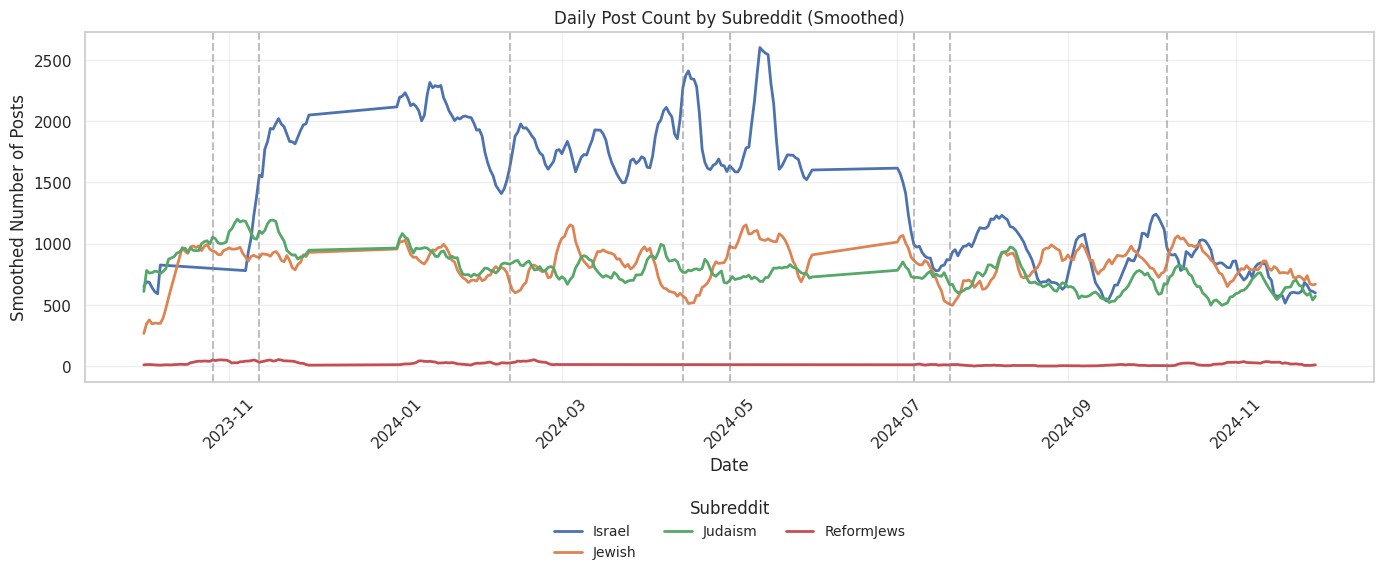

In [ ]:
# Add rolling mean to smooth out the count graph (7 days window)
daily_post_count['smoothed_post_count'] = daily_post_count.groupby('subreddit')['post_count'].transform(lambda x: x.rolling(7, min_periods=1).mean())

# Plot smoothed post count
plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_post_count, x='date', y='smoothed_post_count', hue='subreddit', linewidth=2)

# Highlight the min/max dates for each subreddit
for _, row in post_extreme_dates.iterrows():
    plt.axvline(pd.to_datetime(row['min_posts_date']), color='gray', linestyle='dashed', alpha=0.5)
    plt.axvline(pd.to_datetime(row['max_posts_date']), color='gray', linestyle='dashed', alpha=0.5)

plt.title('Daily Post Count by Subreddit (Smoothed)')
plt.xlabel('Date')
plt.ylabel('Smoothed Number of Posts')
plt.xticks(rotation=45)

# Legend position (under the plot)
plt.legend(
    title='Subreddit',
    bbox_to_anchor=(0.5, -0.3),
    loc='upper center',
    ncol=3,
    fontsize='small',
    frameon=False
)

plt.subplots_adjust(bottom=0.25)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Merge daily sentiment and post count into a single DataFrame for correlation check
daily_sentiment = combined.groupby(['date', 'subreddit'])['sentiment'].mean().reset_index()

merged = pd.merge(daily_sentiment, daily_post_count, on=['date', 'subreddit'], how='inner')

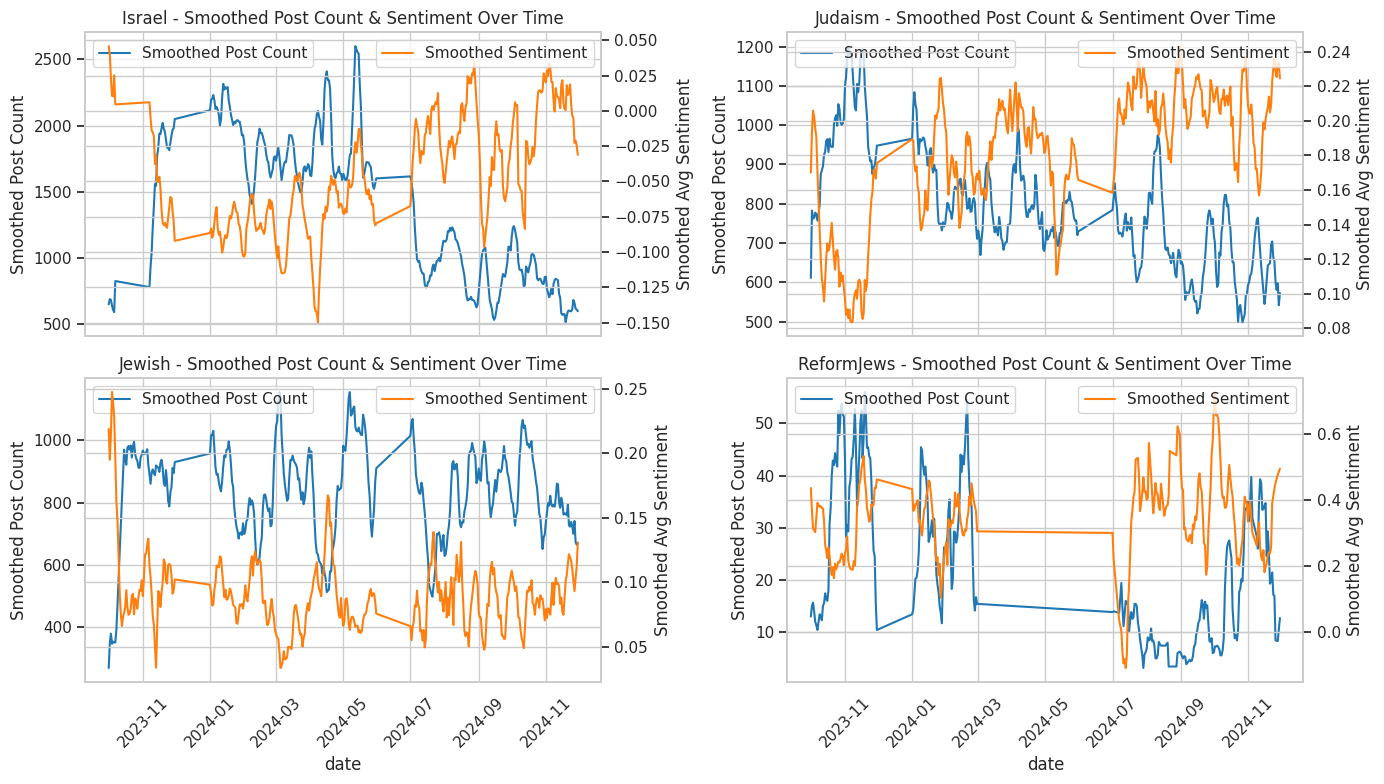

In [ ]:
daily_post_count['smoothed_post_count'] = daily_post_count.groupby('subreddit')['post_count'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
daily_sentiment['smoothed_sentiment'] = daily_sentiment.groupby('subreddit')['sentiment'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

# Get unique subreddits
subreddits = combined['subreddit'].unique()

fig, axes = plt.subplots(
    nrows=(len(subreddits) + 1) // 2,
    ncols=2,
    figsize=(14, 4 * ((len(subreddits) + 1) // 2)),
    sharex=True
)

axes = np.array(axes).reshape(-1, 2)

for idx, subreddit in enumerate(subreddits):
    row, col = divmod(idx, 2)

    ax = axes[row, col]
    ax2 = ax.twinx()

    # Filter smoothed data for this subreddit
    subreddit_posts = daily_post_count[daily_post_count['subreddit'] == subreddit]
    subreddit_sentiment = daily_sentiment[daily_sentiment['subreddit'] == subreddit]

    # Plot smoothed post count
    sns.lineplot(x='date', y='smoothed_post_count', data=subreddit_posts, ax=ax, color='tab:blue', label='Smoothed Post Count')

    # Plot smoothed sentiment
    sns.lineplot(x='date', y='smoothed_sentiment', data=subreddit_sentiment, ax=ax2, color='tab:orange', label='Smoothed Sentiment')

    ax.set_title(f'{subreddit} - Smoothed Post Count & Sentiment Over Time')
    ax.set_ylabel('Smoothed Post Count')
    ax2.set_ylabel('Smoothed Avg Sentiment')

    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.tick_params(axis='x', rotation=45)

if len(subreddits) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


In [ ]:
def prepare_smoothed_data(combined):
    """
    This function takes the combined DataFrame (posts + comments) and:
    1. Calculates daily post count per subreddit.
    2. Calculates daily average sentiment per subreddit.
    3. Applies 7-day rolling mean smoothing.
    4. Merges both smoothed post count and sentiment into one DataFrame.

    Returns:
        smoothed (DataFrame): Combined smoothed post count & sentiment.
    """

    # Make sure 'date' is datetime
    combined['date'] = pd.to_datetime(combined['date'])

    # === Daily Post Count ===
    daily_post_count = combined.groupby(['subreddit', 'date']).size().reset_index(name='post_count')

    # Sort for rolling calculation
    daily_post_count = daily_post_count.sort_values(['subreddit', 'date'])

    # Apply 7-day rolling mean for smoothing post count
    daily_post_count['smoothed_post_count'] = daily_post_count.groupby('subreddit')['post_count'].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )

    # === Daily Sentiment ===
    daily_sentiment = combined.groupby(['subreddit', 'date'])['sentiment'].mean().reset_index()

    # Sort for rolling calculation
    daily_sentiment = daily_sentiment.sort_values(['subreddit', 'date'])

    # Apply 7-day rolling mean for smoothing sentiment
    daily_sentiment['smoothed_sentiment'] = daily_sentiment.groupby('subreddit')['sentiment'].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )

    # === Merge into one DataFrame ===
    smoothed = daily_post_count[['subreddit', 'date', 'smoothed_post_count']].merge(
        daily_sentiment[['subreddit', 'date', 'smoothed_sentiment']],
        on=['subreddit', 'date'],
        how='inner'
    )

    return smoothed


In [ ]:
smoothed = prepare_smoothed_data(combined)

print(smoothed.head())

  subreddit       date  smoothed_post_count  smoothed_sentiment
0    Israel 2023-10-01           651.000000            0.045862
1    Israel 2023-10-02           690.500000            0.040118
2    Israel 2023-10-03           685.333333            0.023573
3    Israel 2023-10-04           642.000000            0.010618
4    Israel 2023-10-05           609.000000            0.010322


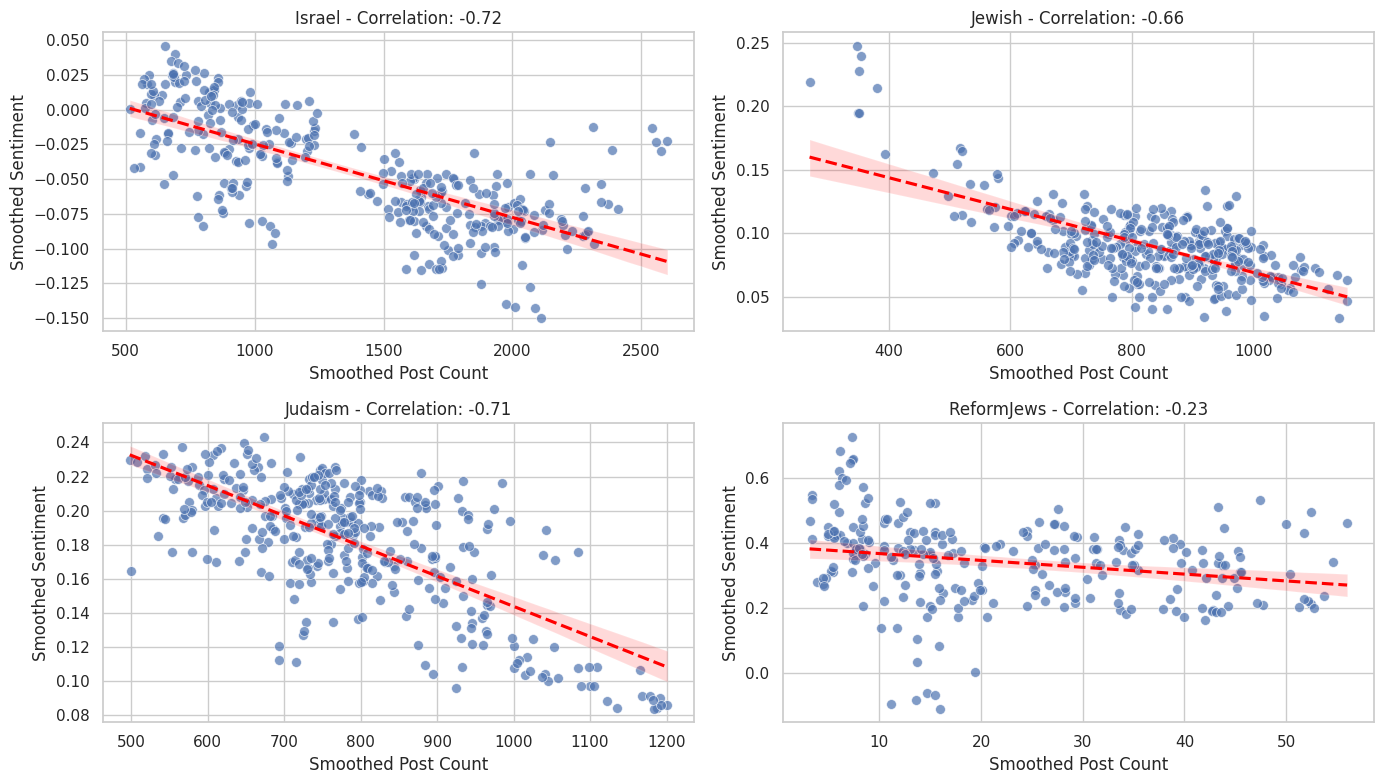

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make sure the smoothed DataFrame exists (run prepare_smoothed_data first)
if 'smoothed' not in globals():
    smoothed = prepare_smoothed_data(combined)

# Create figure with subplots - 2 columns (2 subreddits בשורה)
subreddits = smoothed['subreddit'].unique()
fig, axes = plt.subplots(
    nrows=(len(subreddits) + 1) // 2,
    ncols=2,
    figsize=(14, 4 * ((len(subreddits) + 1) // 2))
)

# Flatten axes if needed
axes = axes.flatten()

# Go over each subreddit
for idx, subreddit in enumerate(subreddits):
    ax = axes[idx]

    # Filter data for the subreddit
    sub = smoothed[smoothed['subreddit'] == subreddit]

    # Scatter plot of post count vs sentiment
    sns.scatterplot(
        x='smoothed_post_count',
        y='smoothed_sentiment',
        data=sub,
        ax=ax,
        s=50, alpha=0.7
    )

    # Add regression line (trend line)
    sns.regplot(
        x='smoothed_post_count',
        y='smoothed_sentiment',
        data=sub,
        ax=ax,
        scatter=False,
        color='red',
        line_kws={'linestyle':'--'}
    )

    # Add title with correlation value
    correlation = sub['smoothed_post_count'].corr(sub['smoothed_sentiment'])
    ax.set_title(f'{subreddit} - Correlation: {correlation:.2f}')

    ax.set_xlabel('Smoothed Post Count')
    ax.set_ylabel('Smoothed Sentiment')

# Remove unused subplot if odd number of subreddits
if len(subreddits) % 2 != 0:
    fig.delaxes(axes[-1])

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from datetime import timedelta
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

/sise/home/weissroy/eden_project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
extreme_dates = pd.DataFrame({
    'subreddit': ['Israel', 'Jewish', 'Judaism', 'ReformJews'],

    # Updated dates based on the smoothed daily analysis
    'min_sentiment_date': ['2024-10-07', '2024-03-05', '2024-05-11', '2024-07-07'],
    'max_sentiment_date': ['2024-11-20', '2023-10-04', '2024-07-20', '2024-09-26'],

    'min_posts_date': ['2024-10-07', '2024-02-11', '2024-07-20', '2024-07-07'],
    'max_posts_date': ['2024-04-14', '2024-05-01', '2023-11-12', '2023-10-26']
})

# Convert to datetime
date_cols = ['min_sentiment_date', 'max_sentiment_date', 'min_posts_date', 'max_posts_date']
for col in date_cols:
    extreme_dates[col] = pd.to_datetime(extreme_dates[col])

# Optional - print to check
print(extreme_dates)


    subreddit min_sentiment_date max_sentiment_date min_posts_date  \
0      Israel         2024-10-07         2024-11-20     2024-10-07   
1      Jewish         2024-03-05         2023-10-04     2024-02-11   
2     Judaism         2024-05-11         2024-07-20     2024-07-20   
3  ReformJews         2024-07-07         2024-09-26     2024-07-07   

  max_posts_date  
0     2024-04-14  
1     2024-05-01  
2     2023-11-12  
3     2023-10-26  


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

import os

os.environ['HF_HOME'] = '/sise/home/weissroy/eden_project/.venv/huggingface_cache'

embedding_model = SentenceTransformer(
    'sentence-transformers/all-MiniLM-L6-v2',
    cache_folder='/sise/home/weissroy/eden_project/.venv/huggingface_cache'
)

In [ ]:
# Function to get date window around peak date (day before, day after)

def get_event_window(date, days_before=1, days_after=1):
    return pd.date_range(start=date - timedelta(days=days_before),
                         end=date + timedelta(days=days_after))

# Function to save plots to HTML (instead of PNG)

def save_plot_as_html(fig, filename):
    """ Save Plotly figure as interactive HTML (works on any server) """
    fig.write_html(f"{filename}.html")
    print(f"Saved plot as: {filename}.html")



# Expanded stopwords list
stopwords = [
    'the', 'of', 'to', 'and', 'in', 'is', 'on', 'for', 'with', 'this', 'that',
    'are', 'was', 'as', 'it', 'at', 'be', 'by', 'an', 'have', 'has', 'had', 'a', 'i',
    'post', 'comment', 'people', 'time', 'subreddit', 'like', 'just', 'said', 'will'
]

# Vectorizer with n-grams and stopwords
vectorizer_model = CountVectorizer(
    stop_words=stopwords,
    ngram_range=(1, 3),
    max_features=5000
)

def analyze_topics_with_bertopic(texts, subreddit, date_type, peak_date):
    if len(texts) < 2:
        print(f" Skipping topic modeling for {subreddit} - {date_type} - {peak_date} (only {len(texts)} posts)")
        return pd.DataFrame()

    print(f"Analyzing {len(texts)} posts for {subreddit} - {date_type} - {peak_date}")

    topic_model = BERTopic(
        nr_topics=10,
        embedding_model=embedding_model,
        vectorizer_model=vectorizer_model
    )

    topics, _ = topic_model.fit_transform(texts)

    topics_df = pd.DataFrame({
        'subreddit': subreddit,
        'date_type': date_type,
        'peak_date': peak_date,
        'text': texts,
        'topic': topics
    })

    topic_labels = topic_model.get_topic_info().set_index('Topic')['Name'].to_dict()
    topics_df['topic_label'] = topics_df['topic'].map(topic_labels)

    # Skip visualizations if no valid topics
    topic_info = topic_model.get_topic_info()
    if len(topic_info) <= 1:
        print(f" No valid topics found for {subreddit} - {date_type} - {peak_date}, skipping visualizations.")
        return topics_df

    # Custom title with subreddit and date
    custom_title = f"TOPIC WORD SCORES - {subreddit} - {peak_date}"

    # Create and modify barchart (compact + bigger font)
    fig_word_scores = topic_model.visualize_barchart(
        top_n_topics=10,
        n_words=15,
        width=800,
        height=400,  # Shorter graph to bring topics closer together
        title=custom_title
    )

    # Adjust layout for better screenshot - tighter spacing & larger fonts
    fig_word_scores.update_layout(
        font=dict(size=16),
        margin=dict(l=10, r=10, t=50, b=10),
        height=600
    )

    # Save barchart to HTML
    save_plot_as_html(fig_word_scores, f"topics_{subreddit}_{date_type}_{peak_date}")

    print(f" Saved visualizations for {subreddit} - {date_type} - {peak_date}")

    return topics_df


In [ ]:
combined['date'] = pd.to_datetime(combined['date'])


# Main loop - Process each subreddit and date

for subreddit in extreme_dates['subreddit'].unique():
    subreddit_dates = extreme_dates[extreme_dates['subreddit'] == subreddit]
    all_topics = []

    for _, row in subreddit_dates.iterrows():
        for date_type in ['min_sentiment_date', 'max_sentiment_date', 'min_posts_date', 'max_posts_date']:
            peak_date = row[date_type]
            window = get_event_window(peak_date)

            print(f"\n=== Processing {subreddit} - {date_type} - {peak_date.date()} ===")
            print(f"Window: {window.date.tolist()}")

            # Filter posts for the subreddit within the date window
            filtered = combined[
                (combined['subreddit'] == subreddit) &
                (combined['date'].isin(window))
            ]

            posts = filtered['full_text'].dropna().tolist()

            # Optional: Sample to limit to 1000 posts max
            if len(posts) > 1000:
                posts = random.sample(posts, 1000)

            if len(posts) == 0:
                print(f"No posts found for {subreddit} - {date_type} - {peak_date.date()}, skipping.")
                continue

            # Analyze topics and collect results
            topics_df = analyze_topics_with_bertopic(posts, subreddit, date_type, peak_date.date())
            if not topics_df.empty:
                all_topics.append(topics_df)

    # Save all results for the subreddit
    if all_topics:
        final_df = pd.concat(all_topics, ignore_index=True)
        final_df.to_csv(f'{subreddit}_topics_analysis.csv', index=False)
        print(f" Saved analysis for {subreddit} to '{subreddit}_topics_analysis.csv'")
    else:
        print(f"No topics found for {subreddit}")

print("Finished processing all subreddits.")


=== Processing Israel - min_sentiment_date - 2024-10-07 ===
Window: [datetime.date(2024, 10, 6), datetime.date(2024, 10, 7), datetime.date(2024, 10, 8)]
Analyzing 1000 posts for Israel - min_sentiment_date - 2024-10-07
Saved plot as: topics_Israel_min_sentiment_date_2024-10-07.html
 Saved visualizations for Israel - min_sentiment_date - 2024-10-07

=== Processing Israel - max_sentiment_date - 2024-11-20 ===
Window: [datetime.date(2024, 11, 19), datetime.date(2024, 11, 20), datetime.date(2024, 11, 21)]
Analyzing 1000 posts for Israel - max_sentiment_date - 2024-11-20
Saved plot as: topics_Israel_max_sentiment_date_2024-11-20.html
 Saved visualizations for Israel - max_sentiment_date - 2024-11-20

=== Processing Israel - min_posts_date - 2024-10-07 ===
Window: [datetime.date(2024, 10, 6), datetime.date(2024, 10, 7), datetime.date(2024, 10, 8)]
Analyzing 1000 posts for Israel - min_posts_date - 2024-10-07
Saved plot as: topics_Israel_min_posts_date_2024-10-07.html
 Saved visualizations f

In [ ]:
# Selected dates for the case studies
selected_cases = [
    {"subreddit": "Israel", "date": "2024-10-07", "event": "Hamas Attack Anniversary"},
    {"subreddit": "Jewish", "date": "2024-05-01", "event": "Antisemitic Campus Protests"},
    {"subreddit": "Israel", "date": "2024-04-14", "event": "Iran Missile Attack"}
]

# Convert selected dates to datetime
for case in selected_cases:
    case["date"] = pd.to_datetime(case["date"])

# Iterate over the selected cases and extract 3 example posts for each
for case in selected_cases:
    subreddit = case['subreddit']
    date = case['date']
    event = case['event']

    print(f"\n--- Examples for {subreddit} on {date.date()} ({event}) ---")

    # Filter combined data for matching subreddit and date
    filtered_posts = combined[
        (combined['subreddit'] == subreddit) &
        (combined['date'].dt.date == date.date())
    ]

    if len(filtered_posts) == 0:
        print(f"No posts found for {subreddit} on {date.date()}")
        continue

    # Sample up to 3 posts (random order for fairness)
    sample_size = min(3, len(filtered_posts))
    sampled_posts = filtered_posts.sample(n=sample_size, random_state=42)

    # Print the posts
    for idx, post in sampled_posts.iterrows():
        print(f"\nPost {idx+1}:")
        print(post['full_text'])

    print(f"\n--- End of examples for {subreddit} on {date.date()} ---")


--- Examples for Israel on 2024-10-07 (Hamas Attack Anniversary) ---

Post 20296:
Zoya Cherkassky's '7October 2023' In the aftermath of October 7, Zoya Cherkassky painted Israelis' experience of the October 7 attack, and the attack itself. Selections are shown above.

Art can help us process experiences, something many of us still are doing a year after the attack.

Paintings allow us to experience, remember and reflect upon an event without looking at photographs, which may be too powerful and painful. Paradoxically, a painting may also evoke broader, deeper experiences and meanings that are more powerful--and sometimes more painful-- than what photographs convey, rendering clear the parallels between the October 7 attack and the Shoah and Pogroms and exiles of the past, for example.

(Note: Although the content above consists of watercolor artwork, the content may be triggering to some as it evokes imagery related to and depicting the October 7 attack and the Holocaust-hence the NSF

In [ ]:
## conclusion

Section: Event-based Topic Analysis using BERTopic
Methodology
In this section, we present the process used to analyze discourse dynamics in selected subreddits, focusing on periods of extreme sentiment and post volume. This analysis was conducted across the subreddits Israel, Jewish, Judaism, and ReformJews, covering multiple peak and low points in sentiment and activity between 2023 and 2024.

Step 1: Identifying Extreme Dates
We performed a preliminary time-series analysis to identify dates with the highest and lowest sentiment scores, as well as the highest and lowest post counts for each subreddit. These dates serve as focal points for deeper content analysis.

Step 2: Defining Analysis Windows
For each extreme date, a 3-day window was defined: the day before, the day itself, and the day after. This window captures both immediate lead-up and follow-up discussions.

Step 3: Extracting Relevant Posts
All posts within these windows were collected from each subreddit. Posts were filtered to ensure they contain textual content (excluding empty or missing text).

Step 4: Topic Modeling with BERTopic
We applied BERTopic, a transformer-based topic modeling method, to the collected posts. BERTopic was configured with:

Embedding model: all-MiniLM-L6-v2
Vectorizer: CountVectorizer with English stopwords and support for unigrams, bigrams, and trigrams.
Number of topics: Limited to a maximum of 10 for interpretability.
Step 5: Visualization and Analysis
For each window, the resulting topics were visualized using BERTopic’s barchart visualization showing the top 15 words per topic. The visualization titles were customized to include the subreddit name and the analyzed date. These visualizations were saved as HTML files to allow later inspection.


Overall Findings
Cross-subreddit Observations
Israel subreddit: Highly responsive to external geopolitical events. Topics frequently included terms like "hamas," "iran," "war," "hostages," "government," and "gaza."
Jewish subreddit: Mixed topics, combining cultural discussions (holidays, traditions) with responses to antisemitic events or global incidents.
Judaism subreddit: Focused more on religious discourse, identity, and internal community debates.
ReformJews subreddit: Much lower volume overall, with discussions focused heavily on identity, internal community issues, and religious reform debates.

# Deep Dive: Selected Case Studies
## Case 1: Israel - October 7, 2024 (Minimum Sentiment Date)
Context:
This date marks the anniversary of the devastating Hamas attack on Israel (October 7, 2023), sparking reflection, trauma discussions, and geopolitical commentary.

Key Topics:
Topic	Top Words
0	they, but, their, hamas
1	india, turkey, government, israel
2	october, 7th, yesterday
5	prague, republic, thank, country
6	france, paris, rio, shameful
Analysis:
Strong focus on Hamas and Israel’s response.
Global reactions (Turkey, India, France) show that the discourse spans international relations.
The discourse blends trauma processing ("yesterday", "7th") with geopolitical commentary.
Overall tone was highly negative, driven by remembrance and blame assignment.

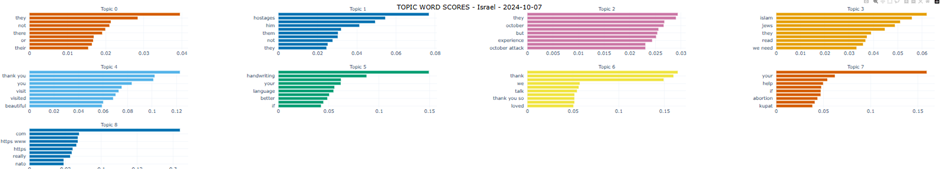

## Case 2: Jewish - May 1, 2024 (Maximum Post Count Date)
Context:
This date coincided with a major antisemitic incident in the US, leading to a surge in discussions in the Jewish subreddit.

Key Topics:
Topic	Top Words
0	ritual, self, god, jewish
1	you, they, but, jewish
4	simchat, torah, celebrate
5	jewish, friends, community
Analysis:
Religious identity defense was a dominant theme, especially around Jewish rituals.
There was extensive discussion about community solidarity in the face of rising antisemitism.
Discussions were both reactive (incident-specific) and reflective (cultural discussions), blending crisis response with cultural self-expression.


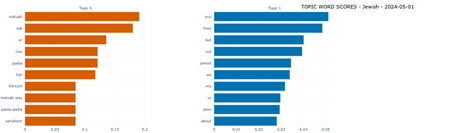

Context:
On April 14, 2024, the Israel subreddit experienced a record spike in posting volume following a direct missile and drone attack by Iran on Israeli territory — the first openly acknowledged large-scale attack of its kind. The event triggered intense global responses and emergency meetings, which drove a surge in Reddit discussions.

Key Topics:
Topic | Top Words
0 | iran, israel, attack, missile
1 | nuclear, facilities, reference
2 | https, en, wikipedia
4 | jordan, saudi, egypt
5 | missiles, ballistic, launch

Analysis:
The discourse was dominated by real-time crisis updates, including breaking news, military analysis, and strategic speculation. Users heavily relied on external sources, such as Wikipedia, and referenced not only Israel and Iran but also regional actors like Jordan and Egypt. The tone was urgent and geopolitical, highlighting how Reddit served both as a news aggregator and a public forum for processing unfolding events.

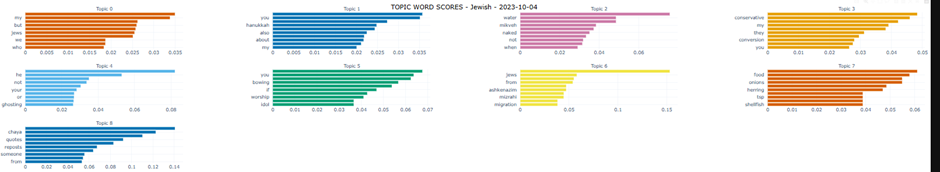

# Sentiment per topic in subreddit

<Figure size 800x400 with 0 Axes>

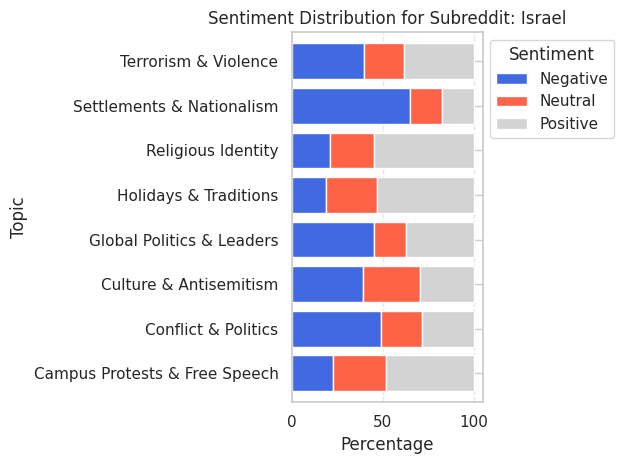

<Figure size 800x400 with 0 Axes>

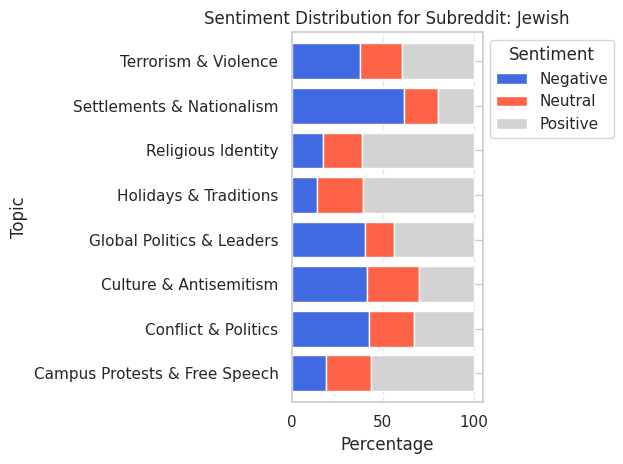

<Figure size 800x400 with 0 Axes>

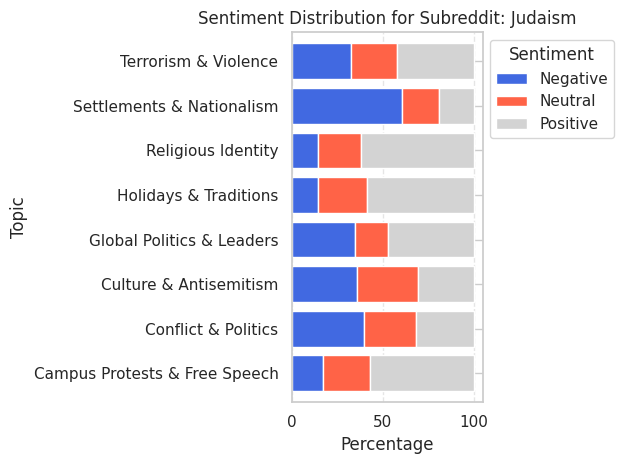

<Figure size 800x400 with 0 Axes>

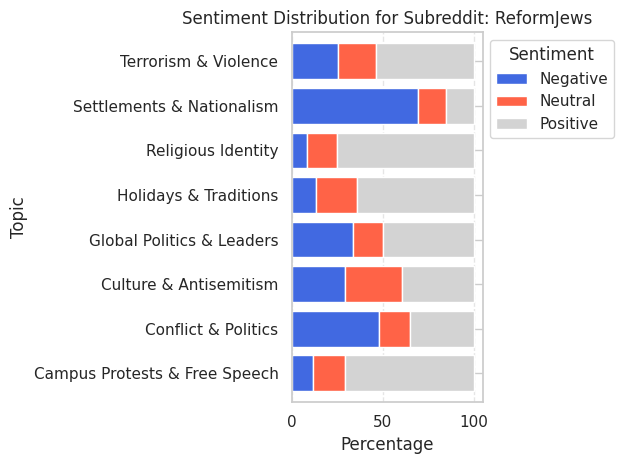

In [ ]:
# Stacked Bar Sentiment Distribution by Topic × Subreddit
dist_topic_subreddit = (
    combined
    .groupby(['subreddit', 'lda_topic_label', 'sentiment_label'])
    .size()
    .unstack(fill_value=0)
)

dist_topic_subreddit_percent = dist_topic_subreddit.div(dist_topic_subreddit.sum(axis=1), axis=0) * 100

for sr in dist_topic_subreddit_percent.index.get_level_values(0).unique():
    df_sub = dist_topic_subreddit_percent.loc[sr]

    plt.figure(figsize=(8, 4))
    df_sub.plot(kind='barh', stacked=True,
                color=['royalblue', 'tomato', 'lightgrey'], width=0.8)
    plt.title(f'Sentiment Distribution for Subreddit: {sr}')
    plt.xlabel('Percentage')
    plt.ylabel('Topic')
    plt.legend(title='Sentiment', bbox_to_anchor=(1, 1))
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
import itertools
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Assuming your DataFrame is called 'combined' and has a column 'subreddit' and 'sentiment_label'
# Example columns: ['subreddit', 'month', 'lda_topic', 'full_text', 'lda_topic_label',
#                   'sentiment', 'sentiment_label', 'year_month']

subreddits = combined['subreddit'].unique()

# Prepare a list to store results
results = []

# Generate all pairwise combinations of subreddits
for s1, s2 in itertools.combinations(subreddits, 2):
    # Filter data for each subreddit
    subset = combined[combined['subreddit'].isin([s1, s2])]

    # Create contingency table: rows = subreddit, columns = sentiment_label
    contingency_table = pd.crosstab(subset['subreddit'], subset['sentiment_label'])

    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    # Append results
    results.append({
        'Subreddit1': s1,
        'Subreddit2': s2,
        'Chi2': chi2,
        'p_value': p_value,
        'degrees_of_freedom': dof
    })

# Convert results to a DataFrame
chi2_results_df = pd.DataFrame(results)
chi2_results_df.sort_values('p_value', inplace=True)

# Print or save the results
print(chi2_results_df)


  Subreddit1  Subreddit2          Chi2        p_value  degrees_of_freedom
0     Israel     Judaism  24752.777111   0.000000e+00                   2
1     Israel      Jewish   7954.528441   0.000000e+00                   2
2     Israel  ReformJews   1769.694112   0.000000e+00                   2
3    Judaism      Jewish   5164.816860   0.000000e+00                   2
5     Jewish  ReformJews    683.641478  3.541109e-149                   2
4    Judaism  ReformJews    277.397460   5.806400e-61                   2


In [ ]:
corr = combined['lda_topic'].corr(combined['sentiment'], method='spearman')
print("Spearman correlation between topic (0-7) and sentiment:", corr)

Spearman correlation between topic (0-7) and sentiment: 0.03340129298647395


The sentiment distribution between r/Israel and r/Jewish differs significantly, with r/Israel displaying more negativity, likely due to its strong focus on political and conflict-related topics, while r/Jewish leans more toward community and cultural discussions. Additionally, sentiment trends over time show that r/ReformJews consistently maintains a more positive tone, reinforcing its role as a space for communal and spiritual discourse, in contrast to the often polarized and crisis-driven conversations in r/Israel.